# Text Classification by author 

In [469]:
import numpy as np
import pandas as pd
import nltk
import os
from pathlib import Path
from nltk.corpus import PlaintextCorpusReader
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, Normalizer
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import make_pipeline
import scipy
from sklearn.decomposition import TruncatedSVD, PCA
import spacy
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
sns.set(font_scale=1.25)
sns.set_style('white')

%matplotlib inline 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Loren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Books


# Gather and Organize Data

In [2]:
# Create list of files
files = os.listdir('texts')

In [6]:
# Print file list
print(files)

['dickens-tale-126.txt', 'doyle-adventures-380.txt', 'emerson-english-230.txt', 'hawthorne-house-64.txt', 'kant-science-146.txt', 'keats-endymion-484.txt', 'milton-paradise-108.txt', 'plato-gorgias-343.txt', 'twain-adventures-27.txt', 'wilde-picture-615.txt']


In [5]:
# Create corpus from files
corpus_root = r'..\unit_4\texts'
texts = PlaintextCorpusReader(corpus_root, '.*')
texts.fileids()

['dickens-tale-126.txt',
 'doyle-adventures-380.txt',
 'emerson-english-230.txt',
 'hawthorne-house-64.txt',
 'kant-science-146.txt',
 'keats-endymion-484.txt',
 'milton-paradise-108.txt',
 'plato-gorgias-343.txt',
 'twain-adventures-27.txt',
 'wilde-picture-615.txt']

In [8]:
# Create Author labels for each book
labels = []
for file in files:
    author = re.search(r'^\w+', file).group()
    labels.append([file, author])

In [90]:
# Read corpus in by paragraph, and create list with author label
para_list = []
joined_paras = []
for book in labels:
    paragraphs = texts.paras(book[0])
    for paragraph in paragraphs:
        para = paragraph[0]
        para_list.append([' '.join(para), book[1]])

# Clean Text

#### Explore the length of the paragraphs

In [91]:
#Display mean paragraph length
para_len = []
for i in para_list:
    para_len.append(len(i[0]))

np.mean(para_len)

75.38333588839491

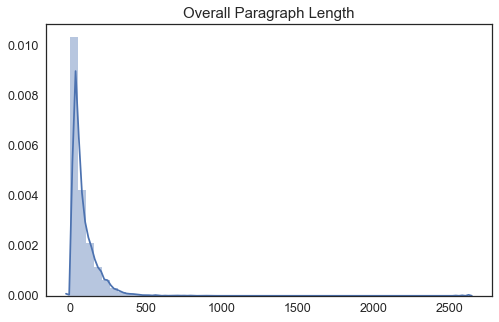

In [93]:
#Plot distribution of paragraph length
plt.figure(figsize=(8,5))
sns.distplot(para_len)
plt.title('Overall Paragraph Length')

plt.show()

In [94]:
# Make dataframe and rename columns
df = pd.DataFrame(para_list)
df.columns = ['paragraph', 'author']
df['length'] = para_len

In [95]:
# display shape of df
df.shape

(13046, 3)

In [475]:
# create list of author names
author_list = df['author'].unique()
print(author_list)

['dickens' 'doyle' 'emerson' 'hawthorne' 'kant' 'keats' 'milton' 'plato'
 'twain' 'wilde']


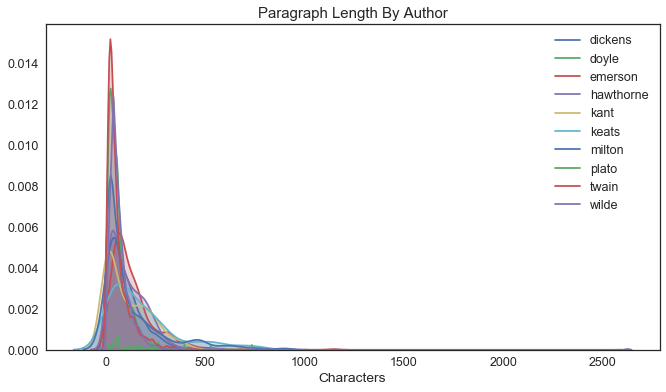

In [97]:
# plot distribution of paragraph length by author
plt.figure(figsize=(11,6))

for author in author_list:
    sns.kdeplot(df['length'][df['author']== author], shade=True, label=author)

plt.title('Paragraph Length By Author')
plt.xlabel('Characters')
plt.show()

##### Short paragraphs will be dropped since they don't contain much information.

In [322]:
# display new shape after dropping short paragraphs
df1 = df.drop(df[df['length'] < 140].index).reset_index(drop=True)
df1.shape

(2097, 3)

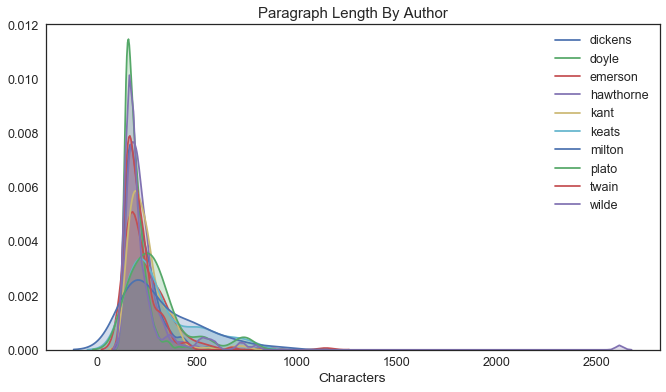

In [323]:
# plot distribution of paragraph length by author after dropping short paragraphs
plt.figure(figsize=(11,6))

for author in author_list:
    sns.kdeplot(df1['length'][df1['author']== author], shade=True, label=author)

plt.title('Paragraph Length By Author')
plt.xlabel('Characters')
plt.show()

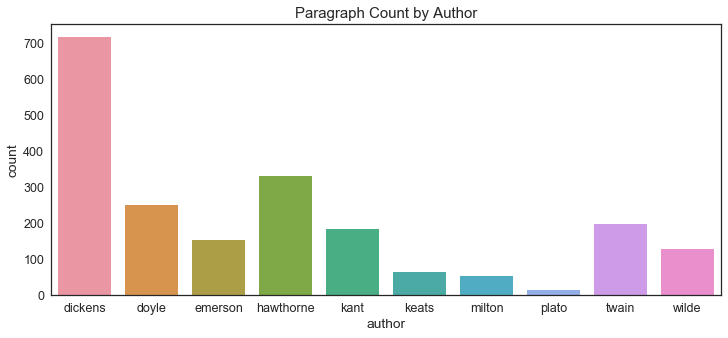

In [324]:
# Plot paragraph count by author
plt.figure(figsize=(12,5))
sns.countplot(x="author", data=df1);
plt.title('Paragraph Count by Author')

plt.show()

In [325]:
# Define function to clean text
def text_cleaner(text):
    #remove double dash  
    text = re.sub(r'--',' ',text)
    #remove numbers
    text = re.sub(r'\d+', '', text)
    #make lowercase
    text = text.lower()
    #remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    #remove extra whitespace
    text = re.sub( '\s+', ' ', text ).strip()
    return text

In [326]:
# Apply text cleaner to paragraphs
df1['paragraph'] = df1['paragraph'].apply(text_cleaner)

In [327]:
# Display head
df1.head()

,paragraph,author,length
0,it was the best of times it was the worst of t...,dickens,631
1,there were a king with a large jaw and a queen...,dickens,185
2,france less favoured on the whole as to matter...,dickens,185
3,all these things and a thousand like them came...,dickens,142
4,with drooping heads and tremulous tails they m...,dickens,187


### Lemmatize words

In [328]:
#initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [329]:
#Define function to lemmatize words
def make_lemma(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

In [330]:
# lemmatize Texts
df1['paragraph'] = df1['paragraph'].apply(make_lemma)

In [331]:
sw = stopwords.words('English')

###  Create TF-IDF feature vector for clustering

In [446]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_features=2000,
                       strip_accents='ascii',
                       analyzer='word',
                       stop_words=sw,
                        lowercase=False,
                       max_df=0.7)

In [447]:
tfidf_features = tfidf.fit_transform(df1['paragraph'])
features = tfidf_features.toarray()
feature_names = tfidf.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)

In [448]:
features_df.head()

,ability,able,absence,accompanied,accompanying,accordance,according,according law,according universal,accordingly,...,yes,yet,yield,yielded,young,young jerry,young lady,young man,younger,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [449]:
# Add a feature for the length of each sentense

#def length(text):
 #   return len(text)

#features_df['sen_length'] = df['sentence'].apply(length)

# Clustering 

In [450]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss_features = ss.fit_transform(features_df)

In [451]:
ss_features

array([[-0.05307009, -0.08933736, -0.0679922 , ..., -0.07803728,
        -0.04620485, -0.08732404],
       [-0.05307009, -0.08933736, -0.0679922 , ..., -0.07803728,
        -0.04620485, -0.08732404],
       [-0.05307009, -0.08933736, -0.0679922 , ..., -0.07803728,
        -0.04620485, -0.08732404],
       ...,
       [-0.05307009, 10.83967324, -0.0679922 , ..., -0.07803728,
        -0.04620485, -0.08732404],
       [-0.05307009, -0.08933736, -0.0679922 , ..., -0.07803728,
        -0.04620485, -0.08732404],
       [-0.05307009, -0.08933736, -0.0679922 , ..., -0.07803728,
        -0.04620485, 11.78458787]])

In [452]:
Y = pd.Categorical(df1['author']).codes
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(ss_features, Y, test_size=.3, random_state=0)

In [476]:
for author in author_list:
    index = df1[df1['author'] == author].index[0]
    print(author, 'code:', Y[index])

dickens code: 0
doyle code: 1
emerson code: 2
hawthorne code: 3
kant code: 4
keats code: 5
milton code: 6
plato code: 7
twain code: 8
wilde code: 9


#### Lets use feature reduction to visualize the actual labels.

In [454]:
SVD = TruncatedSVD(2)
X_train_svd = SVD.fit_transform(X_train)

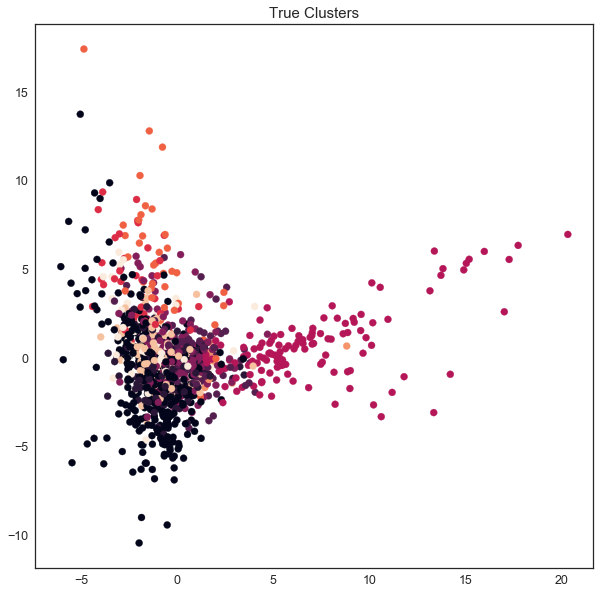

In [455]:
plt.figure(figsize=(10,10))

plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

## K-Means Clustering 

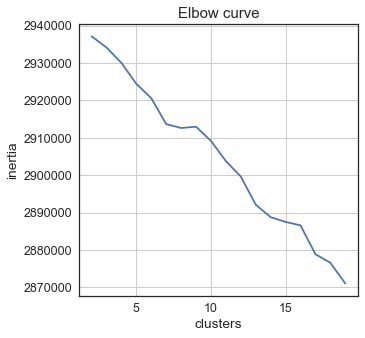

In [358]:
distortion = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(5, 5))
plt.plot(range(2, 20), distortion)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel("clusters")
plt.ylabel('inertia')
plt.show()

In [456]:
#Try with 10 clusters for the 10 different authors
kcluster = KMeans(n_clusters=10, random_state=0)
kcluster.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [457]:
y_train_pred = kcluster.predict(X_train)

In [458]:
Y_train, y_train_pred

(array([0, 5, 0, ..., 1, 1, 5], dtype=int8), array([3, 2, 2, ..., 2, 2, 2]))

In [459]:
clusters = kcluster.cluster_centers_

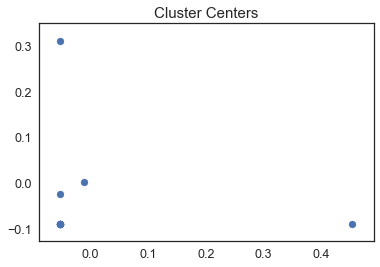

In [460]:
plt.scatter(clusters[:,0], clusters[:,1])
plt.title('Cluster Centers')
plt.show()

In [461]:
np.unique(y_train_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([   3,   13, 1223,   28,    2,   39,  111,    2,   14,   32],
       dtype=int64))

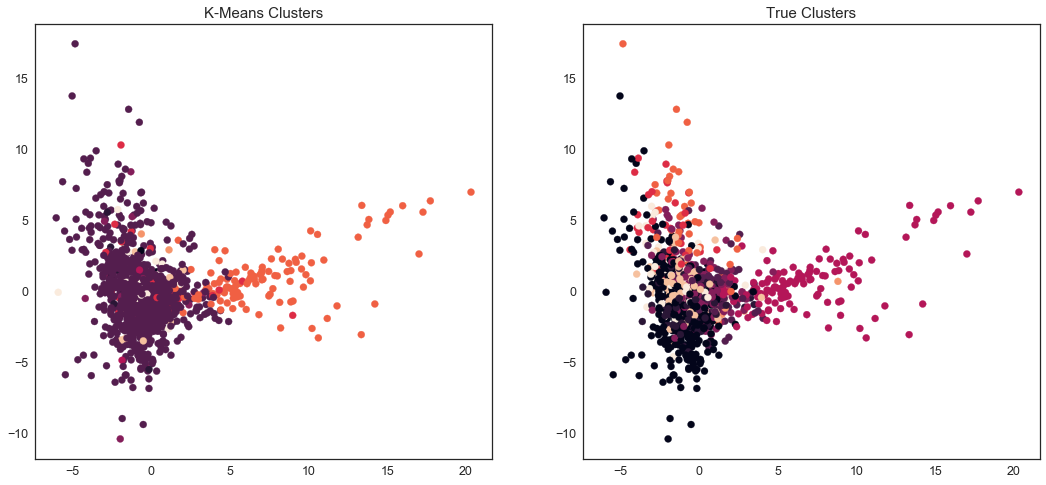

In [462]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('K-Means Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [463]:
print(pd.crosstab(Y_train, y_train_pred))
print('\nAdjusted Rand Score:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0  0   1    2  3  4  5    6  7  8   9
row_0                                    
0      2   2  464  9  1  8    0  0  6   1
1      0   0  173  1  0  5    0  0  1   1
2      0   0   95  4  0  5    3  0  1   0
3      0   0  180  4  1  1    4  0  4  30
4      0   0   22  0  0  6  101  0  0   0
5      0   0   42  2  0  1    0  1  0   0
6      1   0   32  3  0  3    0  1  1   0
7      0   0   10  0  0  0    2  0  0   0
8      0   0  132  3  0  3    0  0  1   0
9      0  11   73  2  0  7    1  0  0   0

Adjusted Rand Score: 0.07777283909918482


# Spectral Clustering 

In [415]:
from sklearn.cluster import SpectralClustering

# 10 clusters
n_clusters=10

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
y_train_pred = sc.fit_predict(X_train)

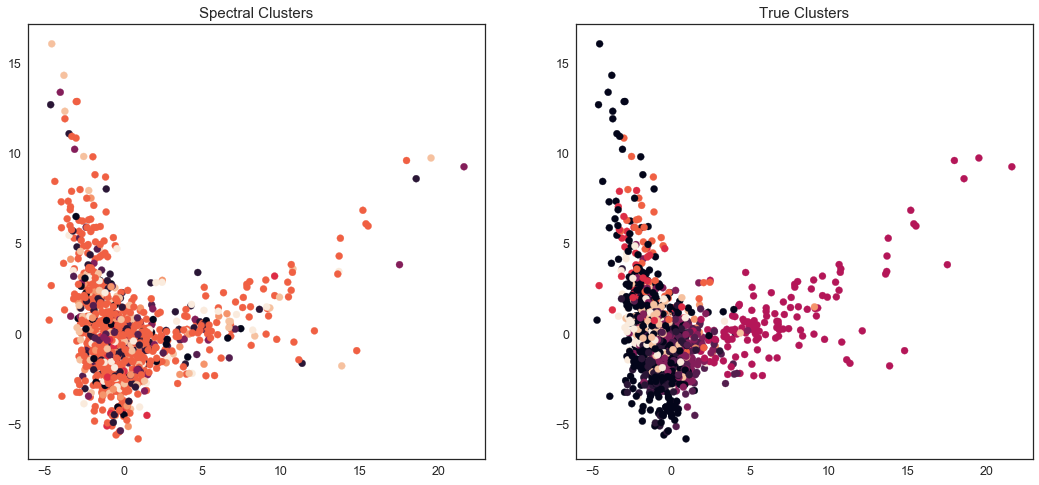

In [416]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('Spectral Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [417]:
print(pd.crosstab(Y_train,y_train_pred))
print('\nAdjusted Rand Score:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0   0   1   2   3  4   5    6   7   8   9
row_0                                        
0      21  38  25  13  2  10  288  27  51  18
1       9  21   6   4  0   4  104   6  19   8
2       3  11   7   5  0   2   64   3   7   6
3       5  23  17   8  0   6  126   6  21  12
4       6   9   5   5  0   2   75   9   9   9
5       4   3   4   0  0   0   29   0   3   3
6       0   4   1   1  0   0   27   2   4   2
7       2   0   3   0  0   0    5   0   1   1
8       5  13   1   6  0   2   87   3  14   8
9       3   8   4   4  0   2   55   4   7   7

Adjusted Rand Score: -0.0032578991479549992


# Affinity Propagation

In [418]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X_train)

y_train_pred = af.predict(X_train)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 40


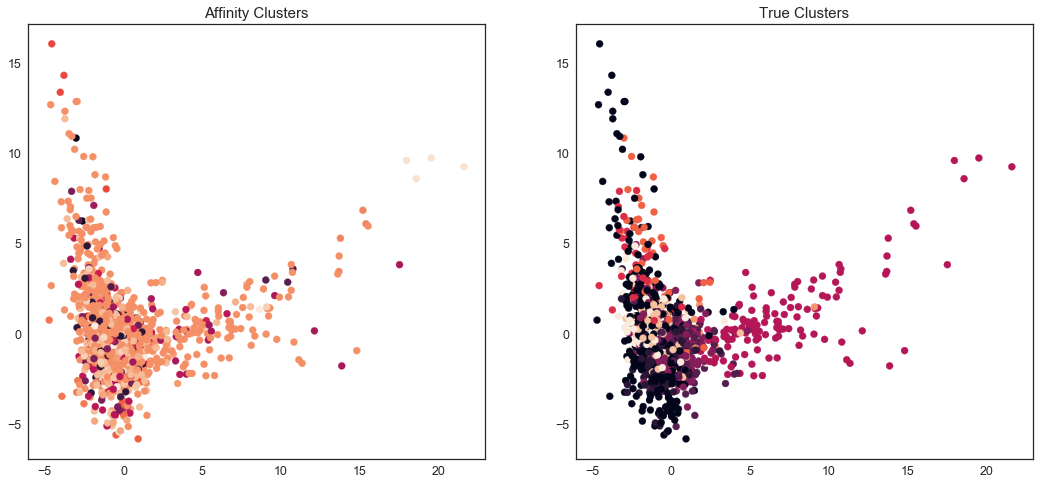

In [419]:
plt.figure(figsize=(18,8))

plt.subplot(1, 2, 1)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_pred)
plt.title('Affinity Clusters')

plt.subplot(1, 2, 2)
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=Y_train)
plt.title('True Clusters')

plt.show()

In [421]:
print(pd.crosstab(Y_train,y_train_pred))
print('\nAdjusted Rand Index:', metrics.adjusted_rand_score(Y_train, y_train_pred))

col_0  0   1   2   3   4   5   6   7   8   9  ...   30  31  32  33  34  35  \
row_0                                         ...                            
0       0   1   0   0   0   9   0   3   4   0 ...  252  11  24  15  52  13   
1       0   0   2   0   0   8   0   0   0   0 ...   81   2   0   1  48   2   
2       0   0   0   1   0   1   0   0   0   0 ...   66  12   0   0  11   0   
3       0   0   0   0   7  12   0   0   0   0 ...  142   7   2   2  16   2   
4       0   0   0   0   0   0   0   0   0   3 ...   85   0   1   3   6   1   
5       0   0   0   0   0   0   1   0   0   0 ...   33   0   1   0   5   0   
6       1   0   0   0   0   0   1   0   0   0 ...   27   1   0   1   5   0   
7       0   0   0   0   0   0   0   0   0   0 ...    7   0   0   0   0   2   
8       0   0   0   0   0   4   0   0   0   0 ...   82   2   2   0  23   1   
9       0   0   0   0   0   6   0   0   0   0 ...   64   1   0   0   9   0   

col_0  36  37  38  39  
row_0                  
0       9   0  

#### The Adjusted Rand Index for all three clustering methods indicates that no method was better than randomly guessing. 

# Unsupervised Feature Generation for Classification by Author

For the unsupervised feature generation, we'll start with a new TF-IDF feature vector with more features.

In [464]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_features=5000,
                       strip_accents='ascii',
                       analyzer='word',
                       stop_words=sw,
                        lowercase=False)

In [465]:
tfidf_features2 = tfidf.fit_transform(df1['paragraph'])
features = tfidf_features2.toarray()
feature_names = tfidf.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)

In [466]:
features_df.head()

,abandoned,abashed,ability,able,absence,absolutely,abuse,access,accident,accompanied,...,yonder,young,young girl,young jerry,young lady,young man,young matthew,young men,younger,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [467]:
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(features_df, Y, test_size=.3, random_state=0)

In [470]:
# Use latent semantic analysis to reduce the features to 500
svd= TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_train)
X_test_lsa = lsa.fit_transform(X_test)

## Logistic Regression

In [482]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()

lr.fit(X_train, Y_train)
print('Score on training data:', lr.score(X_train, Y_train))
print('Score on test data:', lr.score(X_test, Y_test))

Score on training data: 0.7784594410361282
Score on training data: 0.6142857142857143


In [483]:
cross_val_score(lr, X_train, Y_train, cv=10)

array([0.52631579, 0.56666667, 0.56375839, 0.49324324, 0.55479452,
       0.54109589, 0.55172414, 0.57931034, 0.59722222, 0.61971831])

## Logistic Regression with ridge regularization

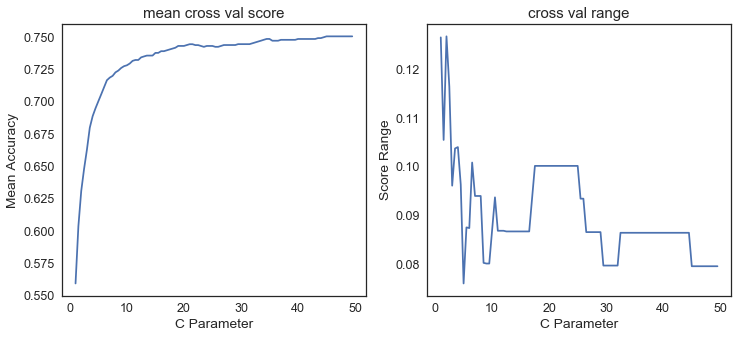

In [490]:
# tune l2 regularization
param_tune = []
#for i in [0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.5, 1, 1.1, 1.2, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]:
#for i in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.01]:
for i in np.arange(1, 50, .5):    
    ridge = LogisticRegression(penalty='l2', C=i)
    ridge.fit(X_train, Y_train)
    score = cross_val_score(ridge, X_train, Y_train, cv=10)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('C Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('C Parameter')
plt.ylabel('Score Range')

plt.show()

In [494]:
from sklearn.metrics import classification_report

ridge = LogisticRegression(penalty='l2', C=45)
ridge.fit(X_train, Y_train)

y_pred = ridge.predict(X_test)
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.72      0.96      0.82       224
          1       0.74      0.61      0.67        70
          2       0.87      0.60      0.71        45
          3       0.84      0.81      0.83       106
          4       0.95      0.96      0.95        55
          5       1.00      0.42      0.59        19
          6       0.89      0.67      0.76        12
          7       0.00      0.00      0.00         4
          8       0.80      0.65      0.72        60
          9       0.89      0.46      0.60        35

avg / total       0.80      0.79      0.77       630



In [495]:
cross_val_score(ridge, X_train, Y_train, cv=10)

array([0.75      , 0.76666667, 0.79194631, 0.73648649, 0.71232877,
       0.73972603, 0.75862069, 0.73793103, 0.74305556, 0.76760563])

# Gradient Boosting Classifier

In [496]:
from sklearn.ensemble import GradientBoostingClassifier

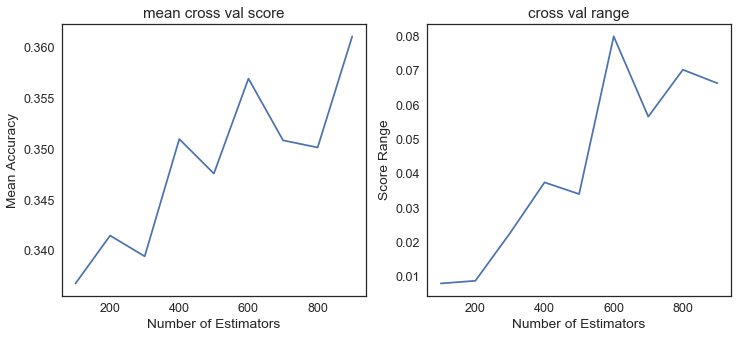

In [499]:
# tune n_estimators
param_tune = []
for i in np.arange(100, 1000, 100):
    
    boost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=i, max_depth=8, min_samples_split=450, min_samples_leaf=42,max_features='sqrt',subsample=0.7)
    score = cross_val_score(boost, X_train, Y_train, cv=5)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('Number of Estimators')
plt.ylabel('Score Range')

plt.show()

Gradient boosting classifier is performing extremely poor based on tuning of Number of estimators.

## Support Vector Machine

In [500]:
from sklearn.svm import SVC

svm = SVC(C=1,  kernel='rbf')

y_pred = svm.fit(X_train, Y_train).predict(X_test)

In [502]:
print('Score on training data:', svm.score(X_train, Y_train))
print('Score on test data:', svm.score(X_test, Y_test))

Score on training data: 0.33605998636673484
Score on training data: 0.35555555555555557


In [501]:
cross_val_score(svm, X_train, Y_train, cv=5)

array([0.33221477, 0.33559322, 0.33673469, 0.33561644, 0.34027778])

## Naive Bayes

In [503]:
from sklearn.naive_bayes import MultinomialNB


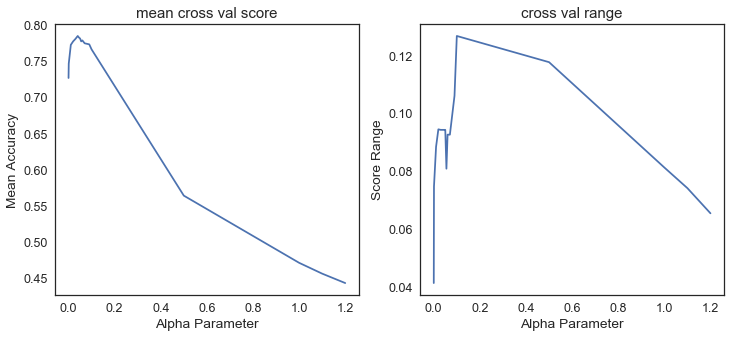

In [508]:
# tune alpha
param_tune = []
for i in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.09, 0.1, 0.5, 1, 1.1, 1.2]:
#for i in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.01]:
#for i in np.arange(1, 50, .5):    
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train, Y_train)
    score = cross_val_score(clf, X_train, Y_train, cv=10)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('Alpha Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('Alpha Parameter')
plt.ylabel('Score Range')

plt.show()

In [509]:
param_tune

,parameter,mean_score,score_range
0,0.0001,0.726581,0.041333
1,0.0010,0.746337,0.074705
2,0.0100,0.772356,0.088410
3,0.0200,0.777129,0.094469
4,0.0300,0.780537,0.094284
5,0.0400,0.784621,0.094284
6,0.0450,0.782532,0.094284
7,0.0500,0.781176,0.094284
8,0.0550,0.777121,0.080861
9,0.0600,0.778501,0.092627


In [510]:
clf = MultinomialNB(alpha=.04)
clf.fit(X_train, Y_train)

print('Score on training data:', clf.score(X_train, Y_train))
print('Score on test data:', clf.score(X_test, Y_test))

Score on training data: 0.9993183367416496
Score on training data: 0.8111111111111111


In [511]:
cross_val_score(clf, X_train, Y_train, cv=10)

array([0.77631579, 0.78      , 0.83221477, 0.77702703, 0.73972603,
       0.82191781, 0.73793103, 0.74482759, 0.82638889, 0.80985915])